In [1]:
suppressPackageStartupMessages({
  library(dataorganizer)
  library(dplyr)
  library(magrittr)
  library(readr)
  library(ggplot2)
  library(Seurat)
  library(SeuratDisk)
  library(pagoda2)
  library(conos)
  library(Matrix)
  library(vpscutils)
  library(pheatmap)
  library(cowplot)
})

devtools::load_all()

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks
Loading required package: cellAdmix

Loading required package: NMF

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attaching package: ‘NMF’


The following objects are masked from ‘package:igraph’:

    algorithm, compare




## Load data

### Spatial

In [9]:
so_spatial <- DatasetPath("human_pancreas", "so.rds") %>% ReadOrCreate(\(){
    cell_meta <- DatasetPath("human_pancreas", "cells.parquet") %>%
        arrow::read_parquet() %>% as.data.frame()

    cm <- DatasetPath("human_pancreas", "cell_feature_matrix.h5") %>%
        Seurat::Read10X_h5() %>% .[["Gene Expression"]]

    Seurat::CreateSeuratObject(cm, meta.data=cell_meta) %>%
        subset(cells=colnames(.)[.$nCount_RNA >=50]) %>%
        NormalizeData() %>% ScaleData() %>%
        RunPCA(features=rownames(.)) %>%
        FindNeighbors(dims=1:30) %>%
        RunUMAP(dims=1:30) %>%
        FindClusters(resolution = 0.25, algorithm=2)
})

In [10]:
so_spatial$annotation <- "unknown"
so_spatial$annotation[so_spatial$RNA_snn_res.0.25 == 1] <- "tumor"
so_spat_subs <- so_spatial %>% subset(cells=colnames(.)[.$annotation == "unknown"])

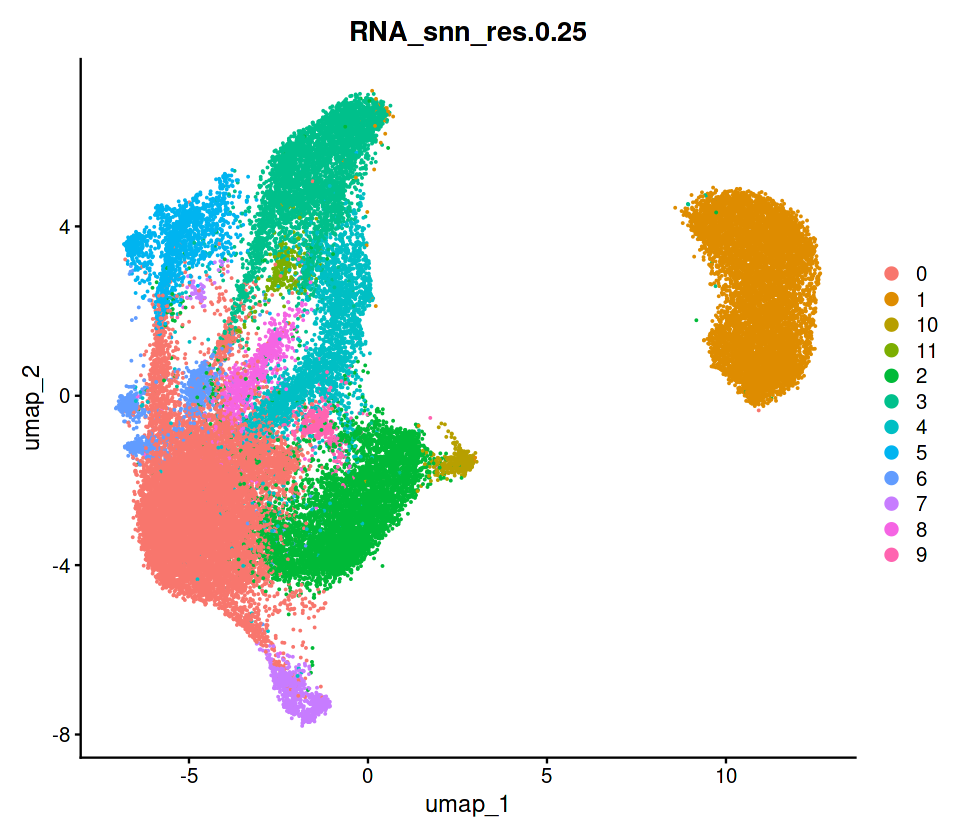

In [11]:
options(repr.plot.width=8, repr.plot.height=7)
DimPlot(so_spatial, group.by="RNA_snn_res.0.25")

### scRNA-seq

In [5]:
cell_meta <- DatasetPath("human_pancreas_rna", "tosti_2020", "meta.tsv") %>% read_delim(delim="\t", show_col_types=FALSE)
cell_annot <- cell_meta %$% setNames(Cluster, Cell)

In [13]:
p2 <- DatasetPath("human_pancreas_rna", "tosti_2020", "p2.rds") %>% ReadOrCreate(\(){
    cm <- DatasetPath("human_pancreas_rna", "tosti_2020", "exprMatrix.tsv") %>% data.table::fread(sep="\t")
    cm %<>% as.data.frame() %>% {set_rownames(.[,2:ncol(.)], .$gene)} %>% as.matrix() %>% as("dgCMatrix")
    rownames(cm) %<>% strsplit(split="|", fixed=TRUE) %>% sapply(`[[`, 1)

    cm_subs <- cm[rownames(so_spat_subs),]

    p2 <- GetPagoda(cm_subs, build.graph=FALSE)
    p2$embeddings$counts$UMAP_paper <- DatasetPath("human_pancreas_rna", "tosti_2020", "Seurat_umap.coords.tsv") %>%
        read.delim(sep="\t", header=FALSE, row.names=1) %>% set_colnames(c("x", "y"))

    p2
})

48424 cells, 377 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

4 overdispersed genes ... 4

persisting ... 

done.

running PCA using 377 OD genes .

.

.

.

 done




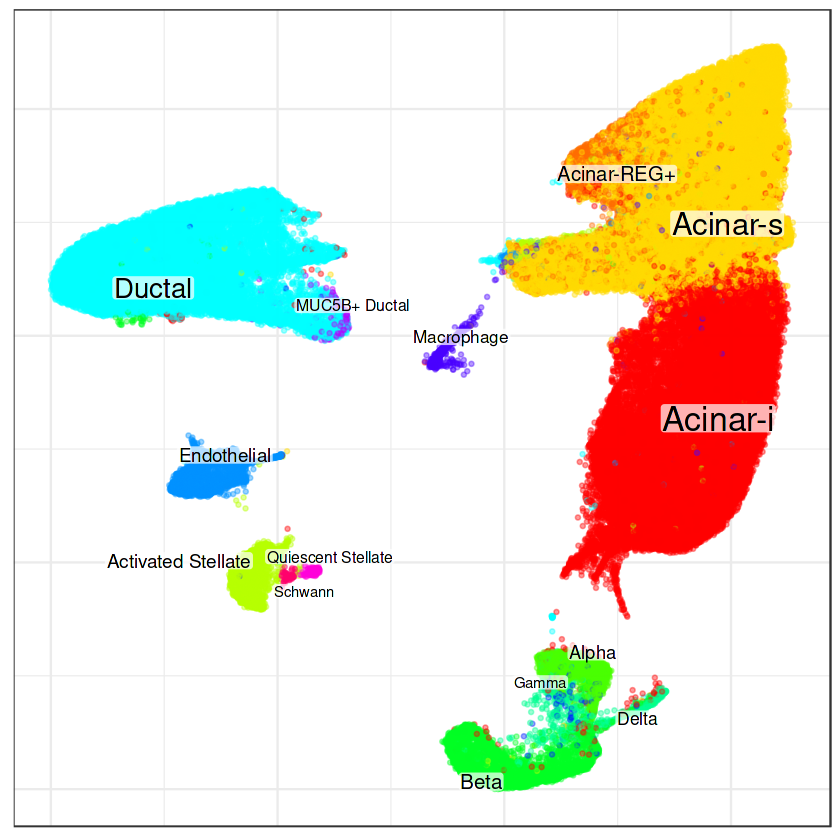

In [14]:
options(repr.plot.width=7, repr.plot.height=7)
p2$plotEmbedding(groups=cell_annot)

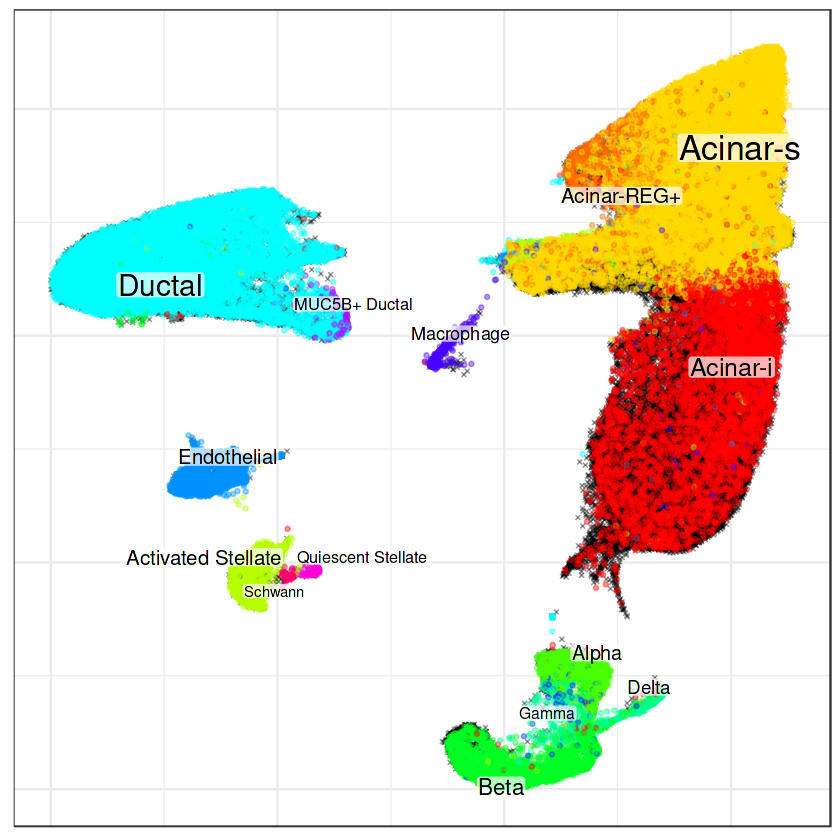

In [15]:
options(repr.plot.width=7, repr.plot.height=7)
p2$plotEmbedding(groups=cell_annot[rownames(p2$counts)], plot.na=-1)

### Basic marker validation

In [16]:
p2_markers <- p2$getDifferentialGenes(groups=cell_annot, append.auc=TRUE)

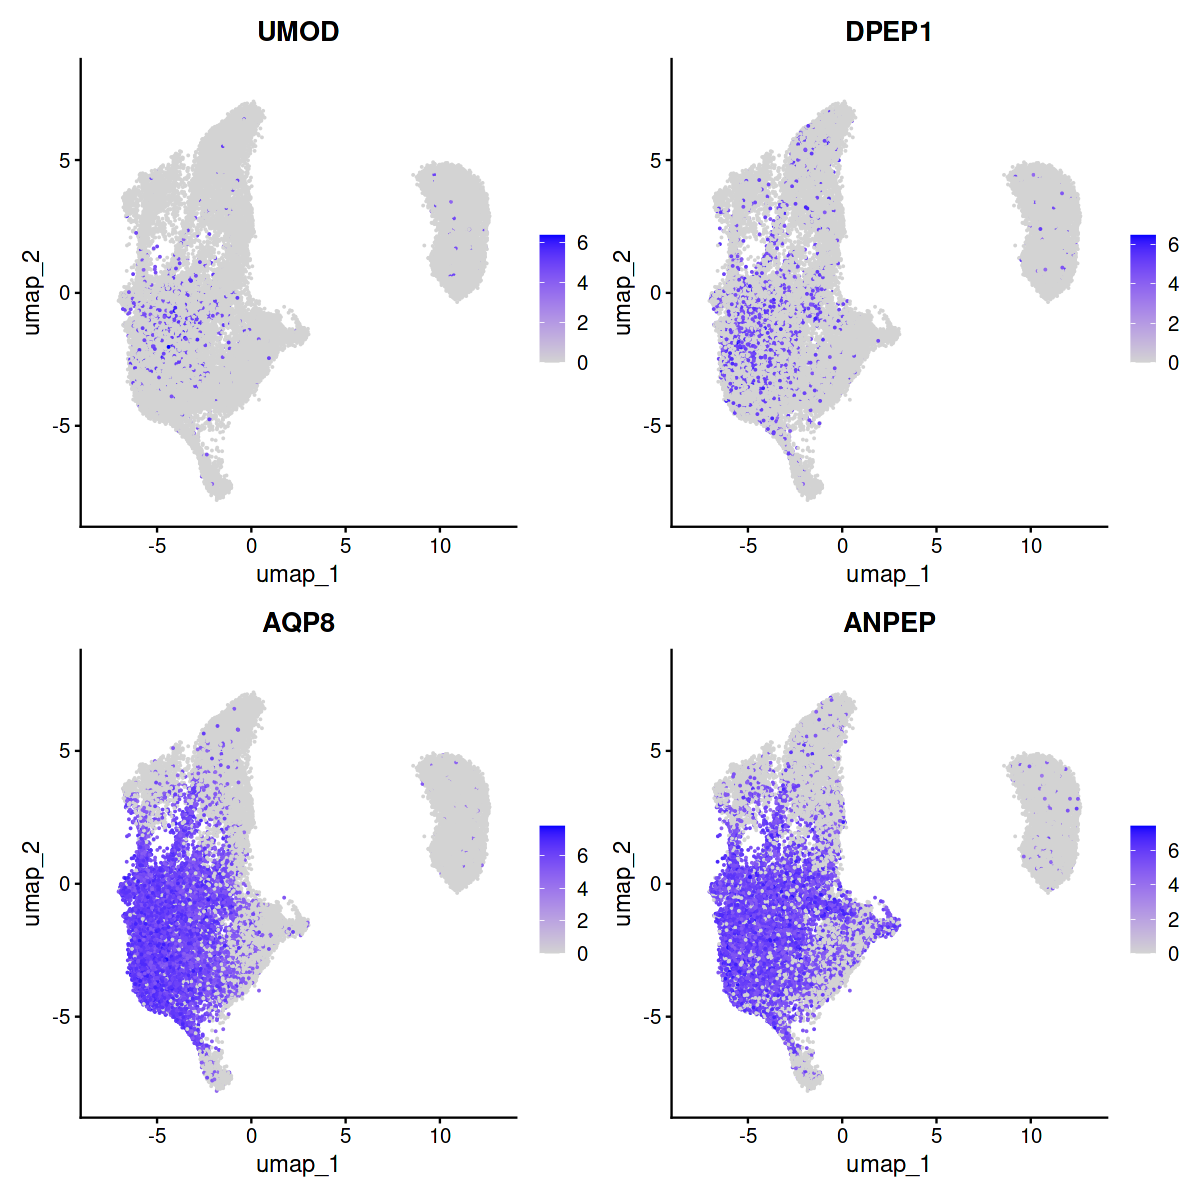

In [17]:
options(repr.plot.width=10, repr.plot.height=10)
acinar_markers <- c("UMOD", "DPEP1", "AQP8", "ANPEP")
FeaturePlot(so_spatial, features=acinar_markers, ncol = 2)

In [18]:
p2_markers$Ductal %>% filter(AUC > 0.6, Specificity > 0.8) %>% arrange(-Specificity)

Z         M        highest fe        Gene  AUC       Specificity
PROX1  37.01245 1.464655 TRUE    0.2722001 PROX1 0.6087426 0.9559351  
CFTR  153.79039 1.813689 TRUE    0.9453280 CFTR  0.9417304 0.9392359  
      Precision ExpressionFraction
PROX1 0.6229384 0.2722001         
CFTR  0.8353708 0.9453280

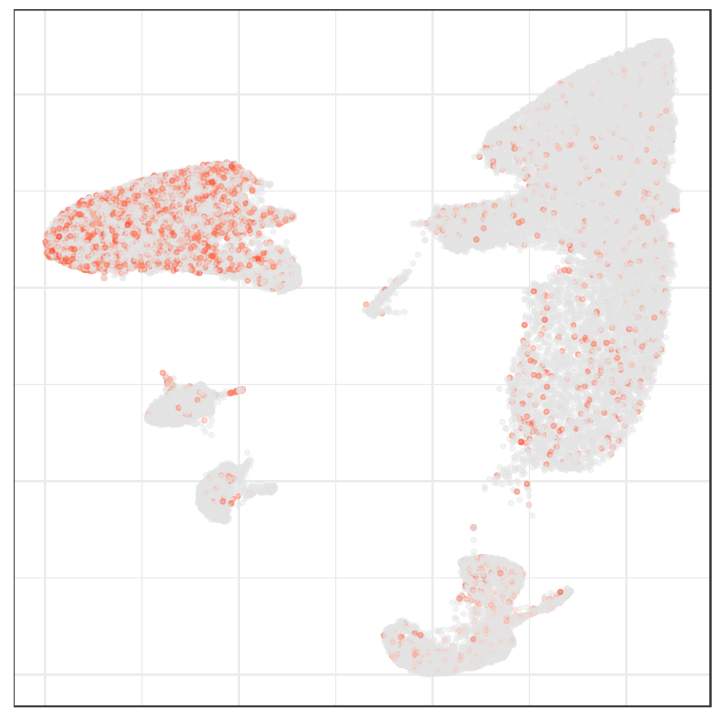

In [19]:
options(repr.plot.width=6, repr.plot.height=6)
p2$plotEmbedding(colors=p2$counts[,"PROX1"], plot.na=FALSE)

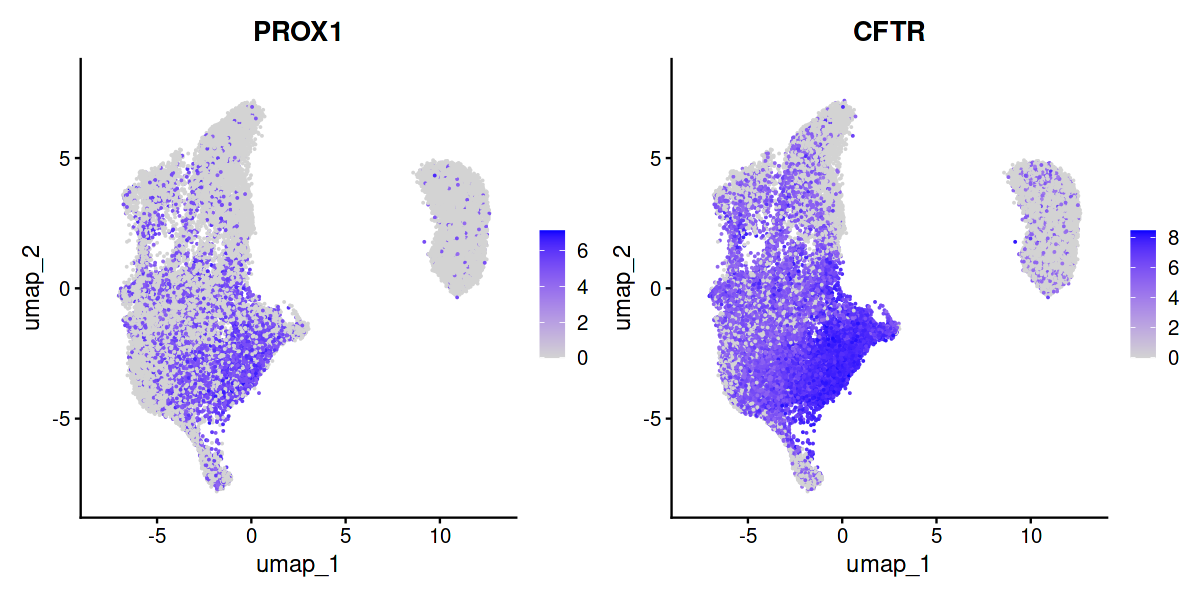

In [20]:
options(repr.plot.width=10, repr.plot.height=5)
acinar_markers <- c("PROX1", "CFTR")
FeaturePlot(so_spatial, features=acinar_markers, ncol = 2)

### Annotation transfer

In [21]:
cell_annot_adj <- cell_annot
cell_annot_adj[startsWith(cell_annot, "Acinar")] <- "Acinar"
cell_annot_adj[cell_annot %in% c("Alpha", "Beta", "Delta", "Gamma")] <- "Alpha/Beta/Delta/Gamma"
cell_annot_adj[cell_annot %in% c("Activated Stellate", "Quiescent Stellate", "Schwann")] <- "Stellate"
cell_annot_adj[cell_annot %in% c("Ductal", "MUC5B+ Ductal")] <- "Ductal"

In [22]:
p2_spatial <- so_spat_subs[["RNA"]]$counts %>%
    GetPagoda(od.genes=rownames(.), n.cores=48, embeding.type="UMAP", n.pcs=40)

31807 cells, 377 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

12 overdispersed genes ... 12

persisting ... 

done.

running PCA using 377 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


05:02:33 UMAP embedding parameters a = 0.3593 b = 1.149

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

05:02:33 Read 31807 rows and found 40 numeric columns

05:02:33 Using Annoy for neighbor search, n_neighbors = 15

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

05:02:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:02:36 Writing NN index file to temp file /tmp/RtmpjDuwR2/fileada026debff7a

05:02:36 Searching Annoy index using 48 threads, search_k = 1500

05:02:37 Annoy recall = 100%

05:02:39 Commencing smooth kNN distance calibration using 48 threads
 with target n_neighbors = 15

05:02:40 Initializing from normalized Laplaci

In [23]:
con <- Conos$new(list(spatial=p2_spatial, rna=p2))
con$buildGraph(k=30, k.self=5, var.scale=TRUE)
con$embedGraph(method="UMAP", min.dist=0.1, spread=2)

found 0 out of 1 cached PCA space pairs ... 

running 1 additional PCA space pairs 

Warning message in commonOverdispersedGenes(r.n, n.odgenes, verbose = verbose):
“samples spatial and rna do not share enough common genes!”


.

 done

inter-sample links using mNN 



.

 done

local pairs 

 done


building graph .



.

done

Convert graph to adjacency list...


Done


Estimate nearest neighbors and commute times...




Estimating hitting distances: 05:03:28.
Done.
Estimating commute distances: 05:03:32.
Hashing adjacency list: 05:03:32.
Done.
Estimating distances: 05:03:37.
Done
Done.
All done!: 05:03:46.


Done


Estimate UMAP embedding...


Warning message in embedKnnGraph(commute.times, n.neighbors = n.neighbors, names = adj.info$names, :
“Maximal number of estimated neighbors is 17. Consider increasing min.visited.verts, min.prob or min.prob.lower.
”
05:03:46 UMAP embedding parameters a = 0.5447 b = 0.8421

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

05:03:46 Converting dataframe to numerical matrix

Warning message in uwot(X = X, n_neighbors = n_neighbors, n_components = n_components, :
“n_components > number of columns in input data: 2 > 1, this may give poor or unexpected results”
05:03:46 Read 80062 rows and found 1 numeric columns

05:03:48 Commencing smooth kNN distance calibration using 96 threads
 with target n_neighbors = 18

05:03:50 Initializing from normalized Laplacian + noise (using RSpectra)

05:03:51 Commencing optimization for 1000 epochs, with 1360756 positive edges using 96 threads

05:04:00 Opti

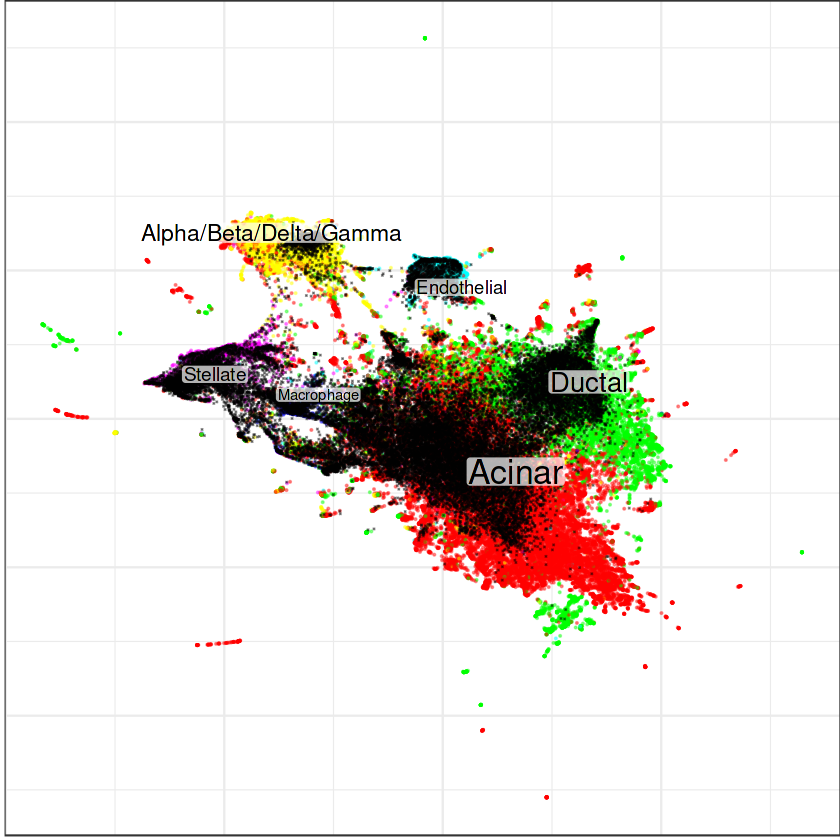

In [25]:
options(repr.plot.width=7, repr.plot.height=7)
con$plotGraph(groups=cell_annot_adj, plot.na=TRUE, size=0.1)

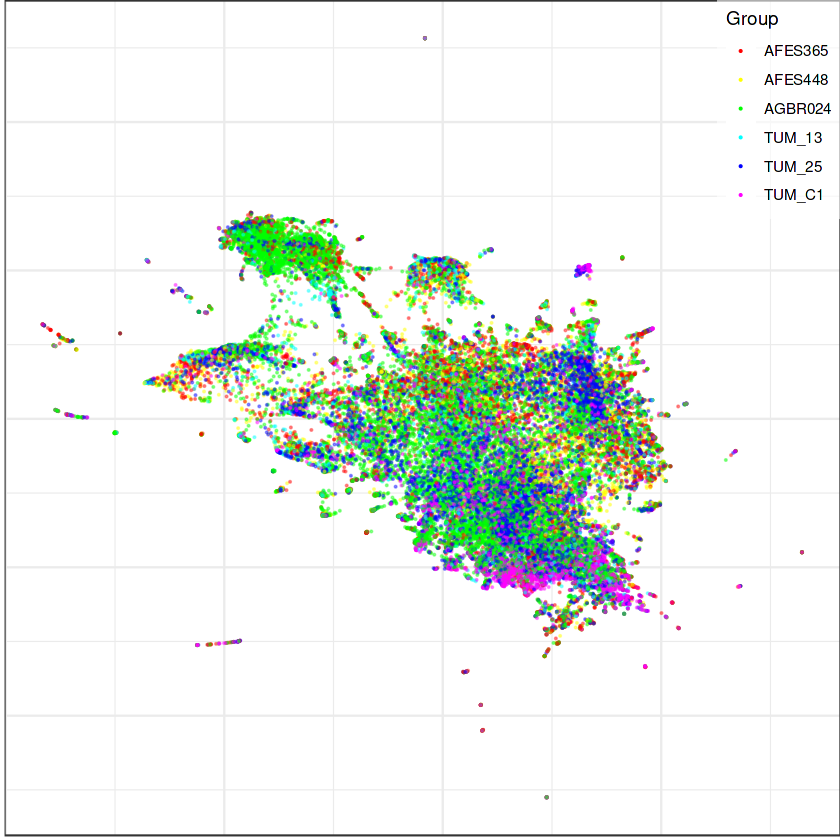

In [26]:
options(repr.plot.width=7, repr.plot.height=7)
t_ann <- cell_meta %$% setNames(patient_ID, Cell)
con$plotGraph(groups=t_ann, plot.na=FALSE, size=0.1, show.legend=TRUE, mark.groups=FALSE, legend.position=c(1, 1))

In [27]:
jcm <- con$getJointCountMatrix()

In [28]:
labels_prop <- con$propagateLabels(labels=cell_annot_adj)

Stop after 15 iterations. Norm: 0.0237517
Min weight: 1.67017e-05, max weight: 0.367879, fading: (10, 0.1)


In [29]:
so_spat_subs$cell_annot_transfered <- labels_prop$labels[colnames(so_spat_subs)]

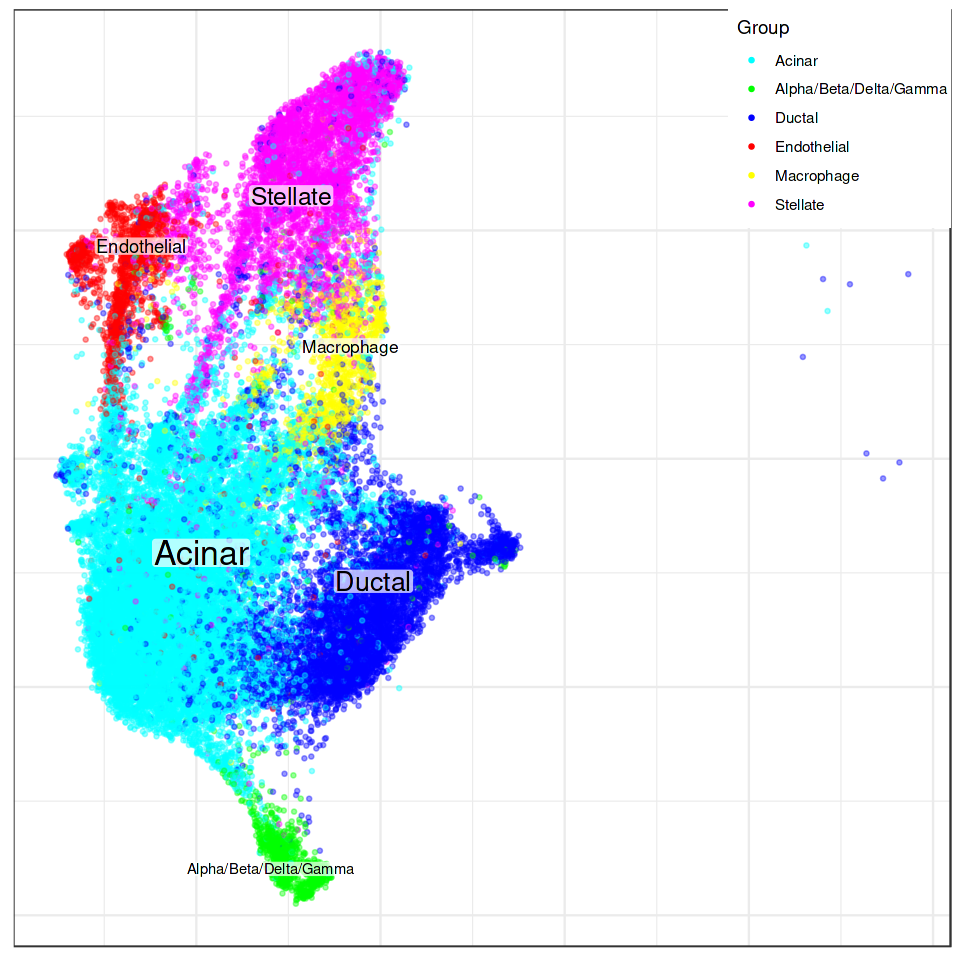

In [30]:
options(repr.plot.width=8, repr.plot.height=8)
Embeddings(so_spat_subs, "umap") %>% sccore::embeddingPlot(
    group=labels_prop$labels, show.legend=TRUE, legend.position=c(1, 1), shuffle.colors=TRUE
)

Smooth labels:

In [31]:
tg <- Graphs(so_spat_subs, "RNA_snn")

In [32]:
adj_mat <- Graphs(so_spat_subs, "RNA_nn") %>% as("dgCMatrix")
diag(adj_mat) <- 0
adj_graph <- igraph::graph_from_adjacency_matrix(adj_mat, weighted=TRUE, mode="max")

In [33]:
labels_smoothed <- labels_prop$label.distribution %>% as.matrix() %>%
    sccore::smoothSignalOnGraph(sccore::heatFilter, graph=adj_graph)

In [34]:
labels_smoothed <- apply(labels_smoothed, 1, which.max) %>% {colnames(labels_smoothed)[.]} %>%
    setNames(rownames(labels_smoothed))

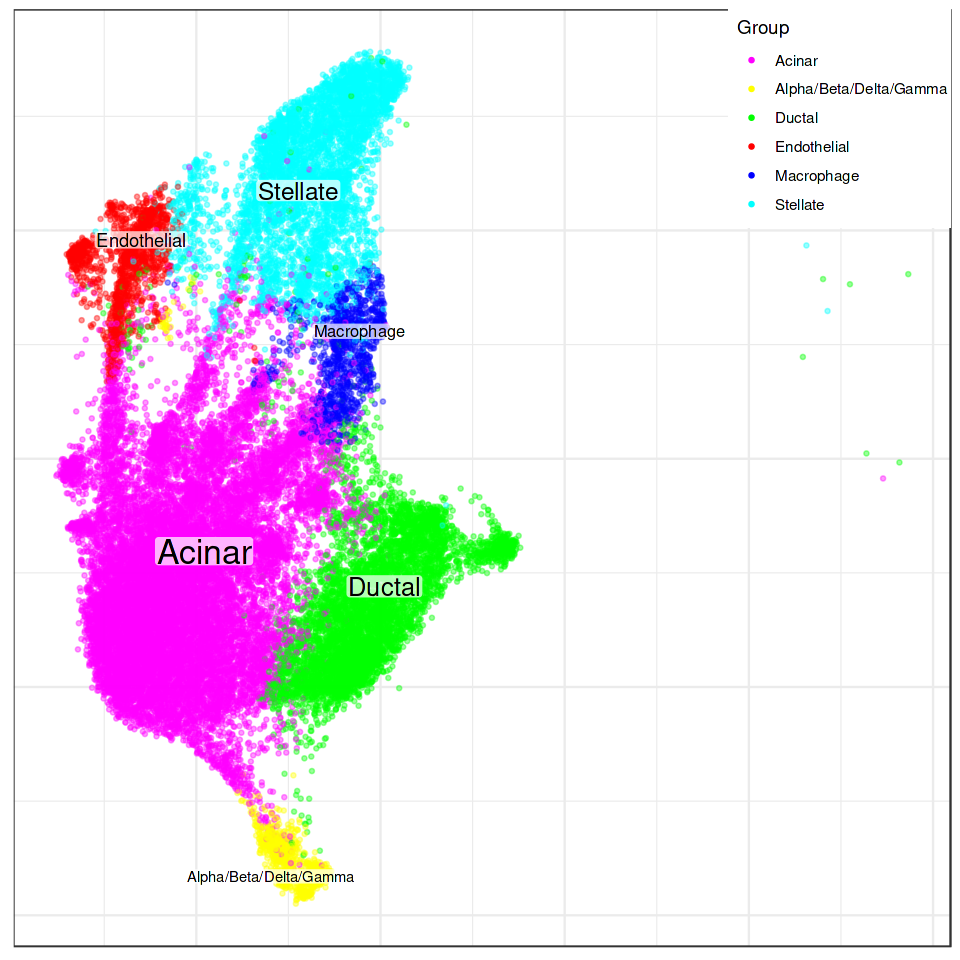

In [35]:
options(repr.plot.width=8, repr.plot.height=8)
Embeddings(so_spat_subs, "umap") %>% sccore::embeddingPlot(
    group=labels_smoothed, show.legend=TRUE, legend.position=c(1, 1), shuffle.colors=TRUE
)

### Marker dotplots

In [36]:
p2_markers_adj <- p2$getDifferentialGenes(groups=cell_annot_adj, append.auc=TRUE)

In [37]:
p2_markers_filt <- lapply(p2_markers_adj, \(df) {
    filter(df, Specificity > 0.7, AUC > 0.6) %>% head(5)
})

In [38]:
so_spat_subs$cell_annot_transfered <- labels_smoothed[colnames(so_spat_subs)]
Idents(so_spat_subs) <- so_spat_subs$cell_annot_transfered %>% factor(levels=sort(unique(.)))

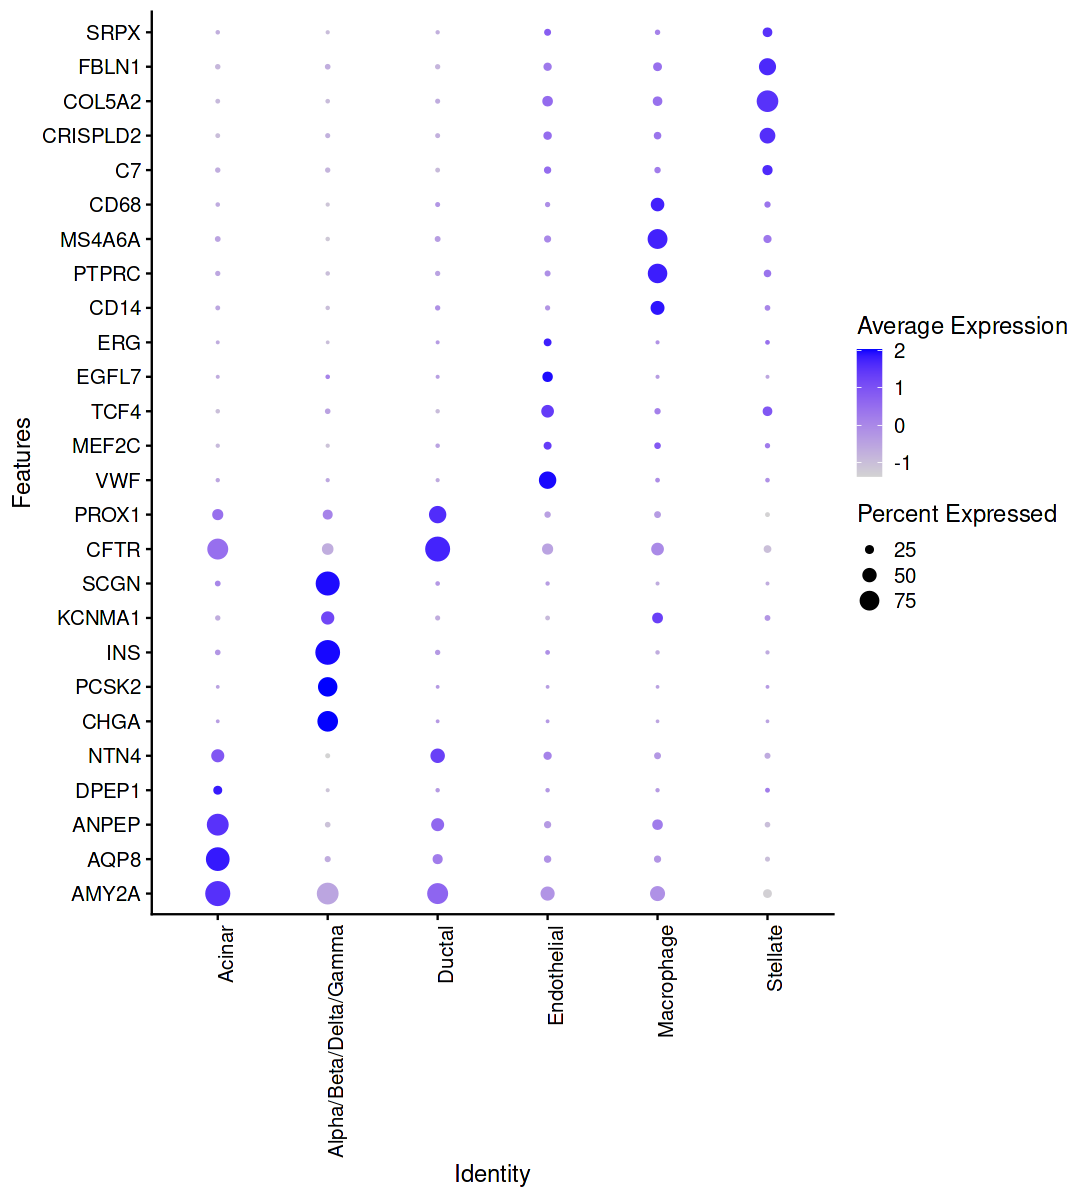

In [39]:
options(repr.plot.width=9, repr.plot.height=10)
p_markers <- p2_markers_filt %>% lapply(\(df) df$Gene) %>% {Reduce(union, .)}
DotPlot(so_spat_subs, p_markers) + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust = 1))

In [44]:
tso <- p2$misc$rawCounts %>% t() %>% .[,rownames(p2$counts)] %>%
    CreateSeuratObject() %>% NormalizeData() %>% ScaleData()
Idents(tso) <- cell_annot_adj[colnames(tso)] %>% factor(levels=sort(unique(.)))

Normalizing layer: counts

Centering and scaling data matrix



Markers on spatial:

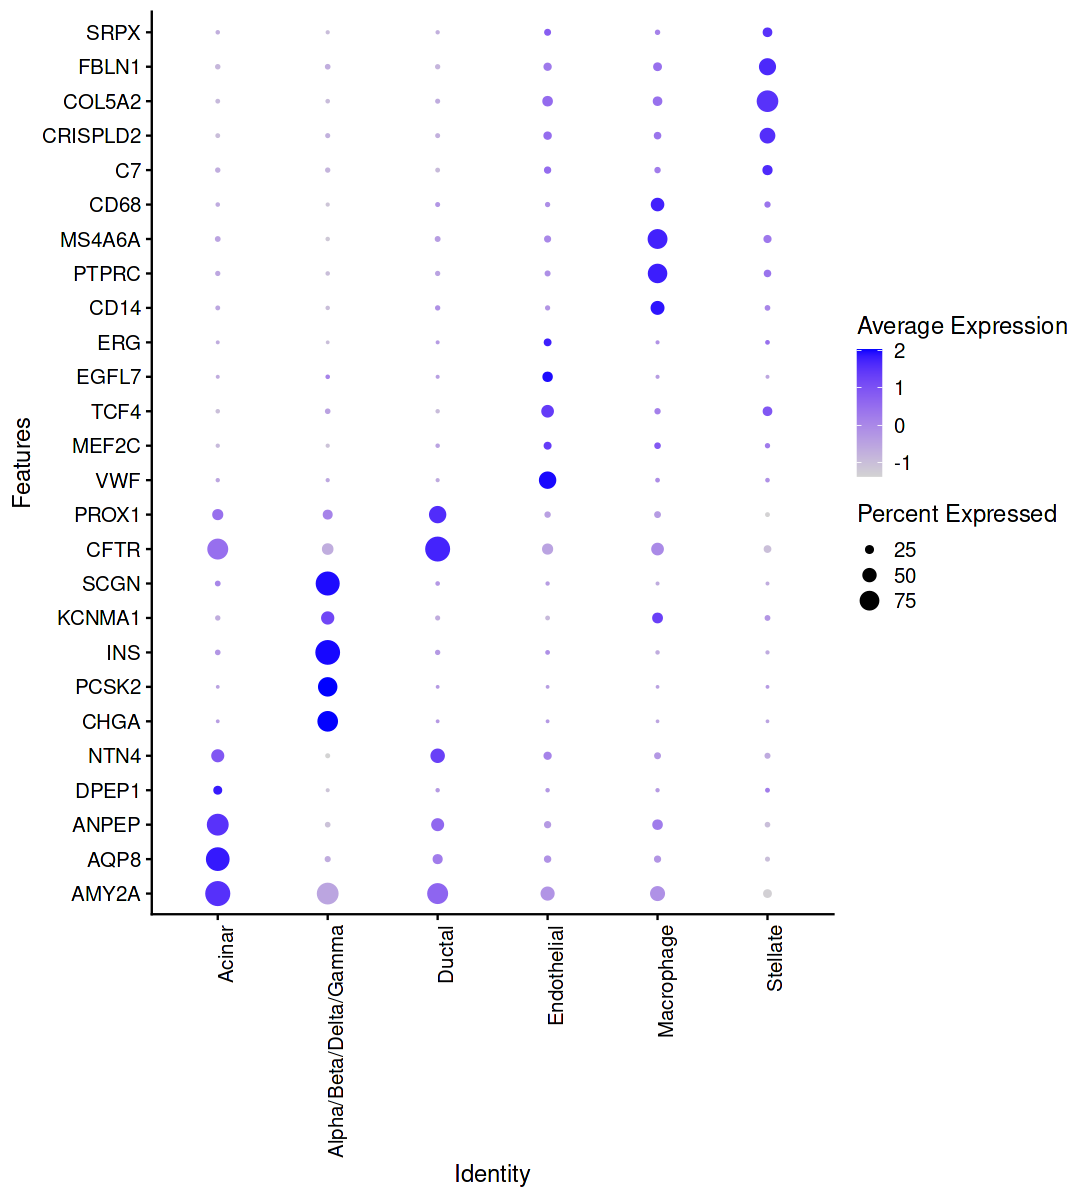

In [45]:
options(repr.plot.width=9, repr.plot.height=10)
p_markers <- p2_markers_filt %>% lapply(\(df) df$Gene) %>% {Reduce(union, .)}
DotPlot(so_spat_subs, p_markers) + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust = 1))

Markers on scRNA-seq:

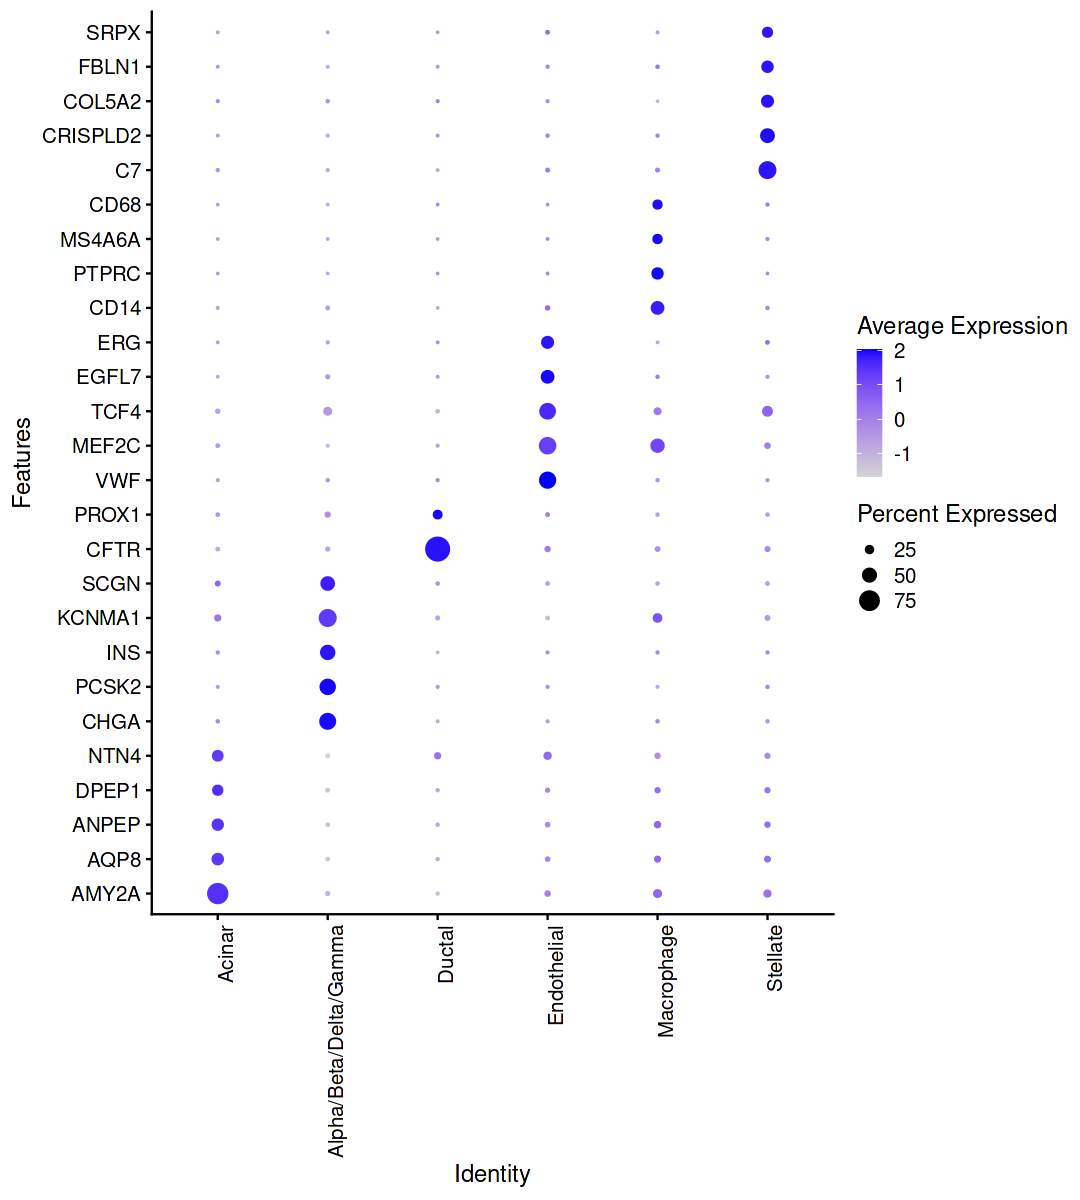

In [46]:
DotPlot(tso, p_markers) + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust = 1))

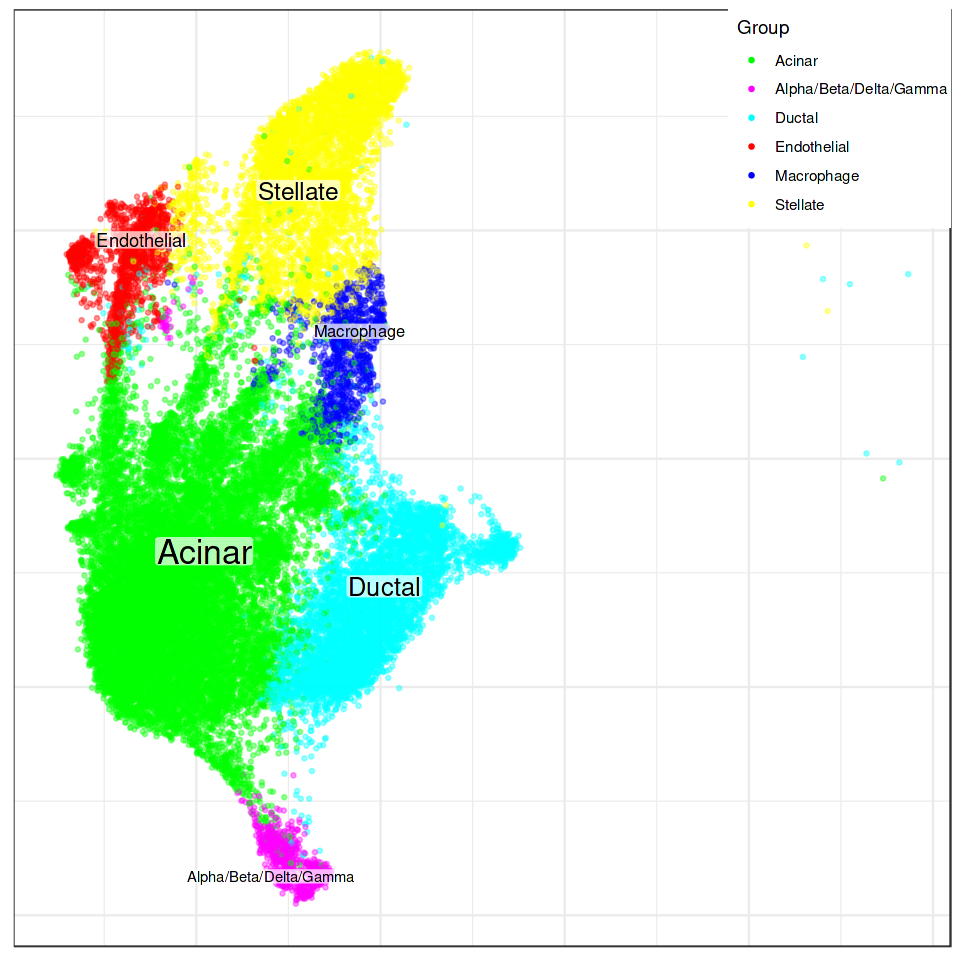

In [47]:
options(repr.plot.width=8, repr.plot.height=8)
Embeddings(so_spat_subs, "umap") %>% sccore::embeddingPlot(
    group=labels_smoothed, show.legend=TRUE, legend.position=c(1, 1), shuffle.colors=TRUE
)

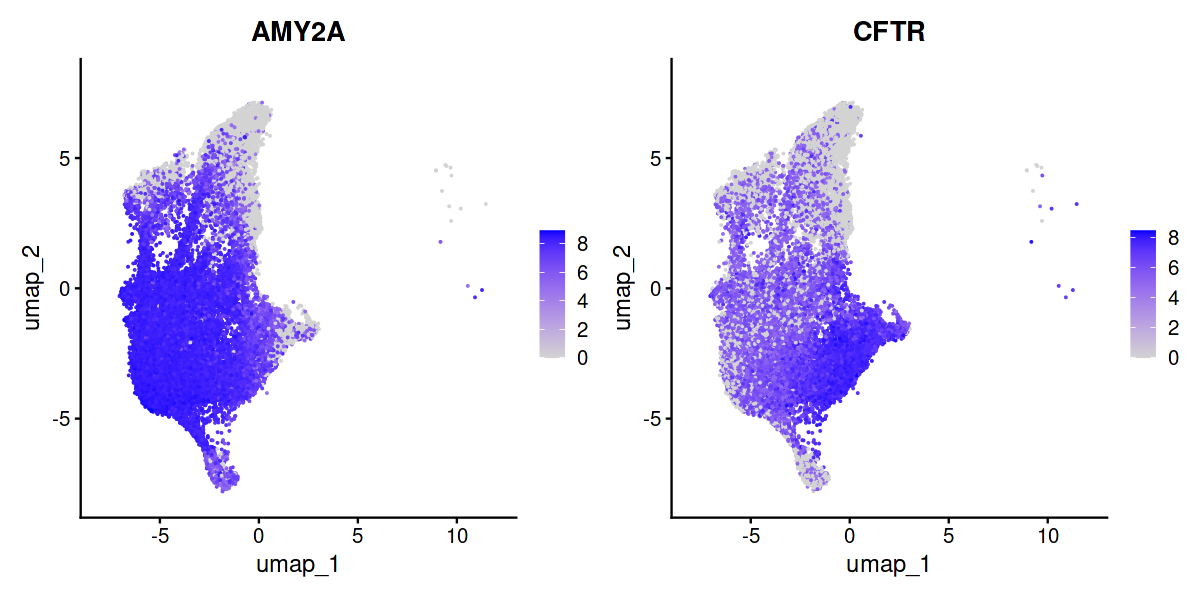

In [48]:
options(repr.plot.width=10, repr.plot.height=5)
FeaturePlot(so_spat_subs, features=c("AMY2A", "CFTR"))

### Save annotation

Spatial:

In [59]:
so_spatial$annotation[colnames(so_spat_subs)] <- labels_smoothed[colnames(so_spat_subs)]

In [61]:
so_spatial$annotation %>%
    {tibble(cell=names(.), annotation=.)} %>%
    write_csv(DatasetPath("human_pancreas", "annotation.csv"))

scRNA-seq:

In [64]:
cell_annot_adj %>%
    {tibble(cell=names(.), annotation=.)} %>%
    write_csv(DatasetPath("human_pancreas_rna", "tosti_2020", "annotation_adj.csv"))

In [65]:
labels_smoothed[names(cell_annot_adj)] %>%
    {tibble(cell=names(.), annotation=.)} %>%
    write_csv(DatasetPath("human_pancreas_rna", "tosti_2020", "annotation_smoothed.csv"))